In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.notebook import tqdm 
#%matplotlib widget

In [2]:
def create_signal(alpha, impulse_amplitude, seed):
    fs = 25000
    fmod = 30
    f_center = 5000
    bandwidth = 1500
    shift = 0

    amp_imp = impulse_amplitude
    alfa = alpha
    skala = 0.5

    varsize = 2*fs
    tt_ts = np.linspace(1/fs,varsize/fs,varsize)
    #szum = np.random.normal(0,skala,varsize) #szum Gaussowski

    szum = levy_stable.rvs(alfa,0,0,skala,varsize, random_state=seed)  #szum alfa-stabilny

    signal_l = 9*impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift)+szum
    return signal_l


In [8]:
#generate data under null, i.e. only noise
alphas = np.linspace(1.1,2,19)

amplitude = 0
mc_iterations = 4000
avg_bcs = []
acc_threshs = np.zeros_like(alphas, dtype = float)

dim = 3*833#417# half period
delay = 50000//dim
#print("delay", delay)
skip = 1#200#0#100
#print(dim*delay)
#print(len(data[0])/24)

#start = min([np.min(d) for d in pds])-0.005
#end = max([np.max(d) for d in pds])+0.005
#print(start,end)
start = 2.98
end = 3.7
grid = np.linspace(start,end,10000)


def generate_data_compute_bc(alpha, amplitude, seed, dim, delay, skip, normalize = True, weighted = True):
    data = create_signal(alpha, amplitude, seed)
    #dim * delay should roughly equal len(time_series)/numer_of_periods
    dim = 3*833#417# half period
    delay = len(data)//dim
    #print("delay", delay)
    skip = 1#200#0#100
    #print(dim*delay)
    #print(len(data[0])/24)

    #print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)

    bc = BettiCurve(predefined_grid=grid)
    betti_curve = bc.fit_transform([pd])
    return betti_curve[0]
    

In [9]:
metric = "max"
avg_bcs=[]
for i in tqdm(range(0,len(alphas))):
    alpha=alphas[i]
    betti_curves = Parallel(n_jobs=-1)(delayed(generate_data_compute_bc)(alpha, 0, k, dim, delay, skip) for k in range(0,mc_iterations))
    avg_bc = np.mean(betti_curves, axis=0)
    avg_bcs.append(avg_bc)
    new_betti_curves = Parallel(n_jobs=-1)(delayed(generate_data_compute_bc)(alpha, 0, mc_iterations+k, dim, delay, skip) for k in range(0,mc_iterations))
    if metric == "l1":
        acc_thresh = np.quantile(pairwise_distances([avg_bc],new_betti_curves, "minkowski", p=1, n_jobs=-1)[0],0.95)
    elif metric == "max":
        acc_thresh = np.quantile(pairwise_distances([avg_bc],new_betti_curves, "chebyshev",n_jobs=-1)[0],0.95)
    acc_threshs[i] = acc_thresh


  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
amplitudes = np.linspace(0,2,21)
test_powers_alpha = np.zeros((len(alphas),len(amplitudes)), dtype=float)
for j in range(0,len(amplitudes)):
    for i in tqdm(range(0,len(alphas))):
        amp = amplitudes[j]
        alpha=alphas[i]
        print("alpha = ",alpha,", amp = ", amp)
        seed = int(2*mc_iterations*(amp+1))
        test_betti_curves = Parallel(n_jobs=-1)(delayed(generate_data_compute_bc)(alpha, amp, seed+k, dim, delay, skip) for k in range(0,mc_iterations))
        if metric == "l1":
            dists = pairwise_distances([avg_bcs[i]],test_betti_curves, "minkowski",p=1,n_jobs=-1)[0]
        elif metric == "max":
            dists = pairwise_distances([avg_bcs[i]],test_betti_curves, "chebyshev",n_jobs=-1)[0]
        #print("computing test power")
        power = np.sum(dists>acc_threshs[i])/mc_iterations
        test_powers_alpha[i][j] =power
    #powers.append(power)

  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.0
alpha =  1.1500000000000001 , amp =  0.0
alpha =  1.2000000000000002 , amp =  0.0
alpha =  1.25 , amp =  0.0
alpha =  1.3 , amp =  0.0
alpha =  1.35 , amp =  0.0
alpha =  1.4000000000000001 , amp =  0.0
alpha =  1.4500000000000002 , amp =  0.0
alpha =  1.5 , amp =  0.0
alpha =  1.55 , amp =  0.0
alpha =  1.6 , amp =  0.0
alpha =  1.65 , amp =  0.0
alpha =  1.7000000000000002 , amp =  0.0
alpha =  1.75 , amp =  0.0
alpha =  1.8 , amp =  0.0
alpha =  1.85 , amp =  0.0
alpha =  1.9 , amp =  0.0
alpha =  1.9500000000000002 , amp =  0.0
alpha =  2.0 , amp =  0.0


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.1
alpha =  1.1500000000000001 , amp =  0.1
alpha =  1.2000000000000002 , amp =  0.1
alpha =  1.25 , amp =  0.1
alpha =  1.3 , amp =  0.1
alpha =  1.35 , amp =  0.1
alpha =  1.4000000000000001 , amp =  0.1
alpha =  1.4500000000000002 , amp =  0.1
alpha =  1.5 , amp =  0.1
alpha =  1.55 , amp =  0.1
alpha =  1.6 , amp =  0.1
alpha =  1.65 , amp =  0.1
alpha =  1.7000000000000002 , amp =  0.1
alpha =  1.75 , amp =  0.1
alpha =  1.8 , amp =  0.1
alpha =  1.85 , amp =  0.1
alpha =  1.9 , amp =  0.1
alpha =  1.9500000000000002 , amp =  0.1
alpha =  2.0 , amp =  0.1


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.2
alpha =  1.1500000000000001 , amp =  0.2
alpha =  1.2000000000000002 , amp =  0.2
alpha =  1.25 , amp =  0.2
alpha =  1.3 , amp =  0.2
alpha =  1.35 , amp =  0.2
alpha =  1.4000000000000001 , amp =  0.2
alpha =  1.4500000000000002 , amp =  0.2
alpha =  1.5 , amp =  0.2
alpha =  1.55 , amp =  0.2
alpha =  1.6 , amp =  0.2
alpha =  1.65 , amp =  0.2
alpha =  1.7000000000000002 , amp =  0.2
alpha =  1.75 , amp =  0.2
alpha =  1.8 , amp =  0.2
alpha =  1.85 , amp =  0.2
alpha =  1.9 , amp =  0.2
alpha =  1.9500000000000002 , amp =  0.2
alpha =  2.0 , amp =  0.2


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.30000000000000004
alpha =  1.1500000000000001 , amp =  0.30000000000000004
alpha =  1.2000000000000002 , amp =  0.30000000000000004
alpha =  1.25 , amp =  0.30000000000000004
alpha =  1.3 , amp =  0.30000000000000004
alpha =  1.35 , amp =  0.30000000000000004
alpha =  1.4000000000000001 , amp =  0.30000000000000004
alpha =  1.4500000000000002 , amp =  0.30000000000000004
alpha =  1.5 , amp =  0.30000000000000004
alpha =  1.55 , amp =  0.30000000000000004
alpha =  1.6 , amp =  0.30000000000000004
alpha =  1.65 , amp =  0.30000000000000004
alpha =  1.7000000000000002 , amp =  0.30000000000000004
alpha =  1.75 , amp =  0.30000000000000004
alpha =  1.8 , amp =  0.30000000000000004
alpha =  1.85 , amp =  0.30000000000000004
alpha =  1.9 , amp =  0.30000000000000004
alpha =  1.9500000000000002 , amp =  0.30000000000000004
alpha =  2.0 , amp =  0.30000000000000004


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.4
alpha =  1.1500000000000001 , amp =  0.4
alpha =  1.2000000000000002 , amp =  0.4
alpha =  1.25 , amp =  0.4
alpha =  1.3 , amp =  0.4
alpha =  1.35 , amp =  0.4
alpha =  1.4000000000000001 , amp =  0.4
alpha =  1.4500000000000002 , amp =  0.4
alpha =  1.5 , amp =  0.4
alpha =  1.55 , amp =  0.4
alpha =  1.6 , amp =  0.4
alpha =  1.65 , amp =  0.4
alpha =  1.7000000000000002 , amp =  0.4
alpha =  1.75 , amp =  0.4
alpha =  1.8 , amp =  0.4
alpha =  1.85 , amp =  0.4
alpha =  1.9 , amp =  0.4
alpha =  1.9500000000000002 , amp =  0.4
alpha =  2.0 , amp =  0.4


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.5
alpha =  1.1500000000000001 , amp =  0.5
alpha =  1.2000000000000002 , amp =  0.5
alpha =  1.25 , amp =  0.5
alpha =  1.3 , amp =  0.5
alpha =  1.35 , amp =  0.5
alpha =  1.4000000000000001 , amp =  0.5
alpha =  1.4500000000000002 , amp =  0.5
alpha =  1.5 , amp =  0.5
alpha =  1.55 , amp =  0.5
alpha =  1.6 , amp =  0.5
alpha =  1.65 , amp =  0.5
alpha =  1.7000000000000002 , amp =  0.5
alpha =  1.75 , amp =  0.5
alpha =  1.8 , amp =  0.5
alpha =  1.85 , amp =  0.5
alpha =  1.9 , amp =  0.5
alpha =  1.9500000000000002 , amp =  0.5
alpha =  2.0 , amp =  0.5


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.6000000000000001
alpha =  1.1500000000000001 , amp =  0.6000000000000001
alpha =  1.2000000000000002 , amp =  0.6000000000000001
alpha =  1.25 , amp =  0.6000000000000001
alpha =  1.3 , amp =  0.6000000000000001
alpha =  1.35 , amp =  0.6000000000000001
alpha =  1.4000000000000001 , amp =  0.6000000000000001
alpha =  1.4500000000000002 , amp =  0.6000000000000001
alpha =  1.5 , amp =  0.6000000000000001
alpha =  1.55 , amp =  0.6000000000000001
alpha =  1.6 , amp =  0.6000000000000001
alpha =  1.65 , amp =  0.6000000000000001
alpha =  1.7000000000000002 , amp =  0.6000000000000001
alpha =  1.75 , amp =  0.6000000000000001
alpha =  1.8 , amp =  0.6000000000000001
alpha =  1.85 , amp =  0.6000000000000001
alpha =  1.9 , amp =  0.6000000000000001
alpha =  1.9500000000000002 , amp =  0.6000000000000001
alpha =  2.0 , amp =  0.6000000000000001


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.7000000000000001
alpha =  1.1500000000000001 , amp =  0.7000000000000001
alpha =  1.2000000000000002 , amp =  0.7000000000000001
alpha =  1.25 , amp =  0.7000000000000001
alpha =  1.3 , amp =  0.7000000000000001
alpha =  1.35 , amp =  0.7000000000000001
alpha =  1.4000000000000001 , amp =  0.7000000000000001
alpha =  1.4500000000000002 , amp =  0.7000000000000001
alpha =  1.5 , amp =  0.7000000000000001
alpha =  1.55 , amp =  0.7000000000000001
alpha =  1.6 , amp =  0.7000000000000001
alpha =  1.65 , amp =  0.7000000000000001
alpha =  1.7000000000000002 , amp =  0.7000000000000001
alpha =  1.75 , amp =  0.7000000000000001
alpha =  1.8 , amp =  0.7000000000000001
alpha =  1.85 , amp =  0.7000000000000001
alpha =  1.9 , amp =  0.7000000000000001
alpha =  1.9500000000000002 , amp =  0.7000000000000001
alpha =  2.0 , amp =  0.7000000000000001


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.8
alpha =  1.1500000000000001 , amp =  0.8
alpha =  1.2000000000000002 , amp =  0.8
alpha =  1.25 , amp =  0.8
alpha =  1.3 , amp =  0.8
alpha =  1.35 , amp =  0.8
alpha =  1.4000000000000001 , amp =  0.8
alpha =  1.4500000000000002 , amp =  0.8
alpha =  1.5 , amp =  0.8
alpha =  1.55 , amp =  0.8
alpha =  1.6 , amp =  0.8
alpha =  1.65 , amp =  0.8
alpha =  1.7000000000000002 , amp =  0.8
alpha =  1.75 , amp =  0.8
alpha =  1.8 , amp =  0.8
alpha =  1.85 , amp =  0.8
alpha =  1.9 , amp =  0.8
alpha =  1.9500000000000002 , amp =  0.8
alpha =  2.0 , amp =  0.8


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  0.9
alpha =  1.1500000000000001 , amp =  0.9
alpha =  1.2000000000000002 , amp =  0.9
alpha =  1.25 , amp =  0.9
alpha =  1.3 , amp =  0.9
alpha =  1.35 , amp =  0.9
alpha =  1.4000000000000001 , amp =  0.9
alpha =  1.4500000000000002 , amp =  0.9
alpha =  1.5 , amp =  0.9
alpha =  1.55 , amp =  0.9
alpha =  1.6 , amp =  0.9
alpha =  1.65 , amp =  0.9
alpha =  1.7000000000000002 , amp =  0.9
alpha =  1.75 , amp =  0.9
alpha =  1.8 , amp =  0.9
alpha =  1.85 , amp =  0.9
alpha =  1.9 , amp =  0.9
alpha =  1.9500000000000002 , amp =  0.9
alpha =  2.0 , amp =  0.9


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.0
alpha =  1.1500000000000001 , amp =  1.0
alpha =  1.2000000000000002 , amp =  1.0
alpha =  1.25 , amp =  1.0
alpha =  1.3 , amp =  1.0
alpha =  1.35 , amp =  1.0
alpha =  1.4000000000000001 , amp =  1.0
alpha =  1.4500000000000002 , amp =  1.0
alpha =  1.5 , amp =  1.0
alpha =  1.55 , amp =  1.0
alpha =  1.6 , amp =  1.0
alpha =  1.65 , amp =  1.0
alpha =  1.7000000000000002 , amp =  1.0
alpha =  1.75 , amp =  1.0
alpha =  1.8 , amp =  1.0
alpha =  1.85 , amp =  1.0
alpha =  1.9 , amp =  1.0
alpha =  1.9500000000000002 , amp =  1.0
alpha =  2.0 , amp =  1.0


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.1
alpha =  1.1500000000000001 , amp =  1.1
alpha =  1.2000000000000002 , amp =  1.1
alpha =  1.25 , amp =  1.1
alpha =  1.3 , amp =  1.1
alpha =  1.35 , amp =  1.1
alpha =  1.4000000000000001 , amp =  1.1
alpha =  1.4500000000000002 , amp =  1.1
alpha =  1.5 , amp =  1.1
alpha =  1.55 , amp =  1.1
alpha =  1.6 , amp =  1.1
alpha =  1.65 , amp =  1.1
alpha =  1.7000000000000002 , amp =  1.1
alpha =  1.75 , amp =  1.1
alpha =  1.8 , amp =  1.1
alpha =  1.85 , amp =  1.1
alpha =  1.9 , amp =  1.1
alpha =  1.9500000000000002 , amp =  1.1
alpha =  2.0 , amp =  1.1


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.2000000000000002
alpha =  1.1500000000000001 , amp =  1.2000000000000002
alpha =  1.2000000000000002 , amp =  1.2000000000000002
alpha =  1.25 , amp =  1.2000000000000002
alpha =  1.3 , amp =  1.2000000000000002
alpha =  1.35 , amp =  1.2000000000000002
alpha =  1.4000000000000001 , amp =  1.2000000000000002
alpha =  1.4500000000000002 , amp =  1.2000000000000002
alpha =  1.5 , amp =  1.2000000000000002
alpha =  1.55 , amp =  1.2000000000000002
alpha =  1.6 , amp =  1.2000000000000002
alpha =  1.65 , amp =  1.2000000000000002
alpha =  1.7000000000000002 , amp =  1.2000000000000002
alpha =  1.75 , amp =  1.2000000000000002
alpha =  1.8 , amp =  1.2000000000000002
alpha =  1.85 , amp =  1.2000000000000002
alpha =  1.9 , amp =  1.2000000000000002
alpha =  1.9500000000000002 , amp =  1.2000000000000002
alpha =  2.0 , amp =  1.2000000000000002


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.3
alpha =  1.1500000000000001 , amp =  1.3
alpha =  1.2000000000000002 , amp =  1.3
alpha =  1.25 , amp =  1.3
alpha =  1.3 , amp =  1.3
alpha =  1.35 , amp =  1.3
alpha =  1.4000000000000001 , amp =  1.3
alpha =  1.4500000000000002 , amp =  1.3
alpha =  1.5 , amp =  1.3
alpha =  1.55 , amp =  1.3
alpha =  1.6 , amp =  1.3
alpha =  1.65 , amp =  1.3
alpha =  1.7000000000000002 , amp =  1.3
alpha =  1.75 , amp =  1.3
alpha =  1.8 , amp =  1.3
alpha =  1.85 , amp =  1.3
alpha =  1.9 , amp =  1.3
alpha =  1.9500000000000002 , amp =  1.3
alpha =  2.0 , amp =  1.3


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.4000000000000001
alpha =  1.1500000000000001 , amp =  1.4000000000000001
alpha =  1.2000000000000002 , amp =  1.4000000000000001
alpha =  1.25 , amp =  1.4000000000000001
alpha =  1.3 , amp =  1.4000000000000001
alpha =  1.35 , amp =  1.4000000000000001
alpha =  1.4000000000000001 , amp =  1.4000000000000001
alpha =  1.4500000000000002 , amp =  1.4000000000000001
alpha =  1.5 , amp =  1.4000000000000001
alpha =  1.55 , amp =  1.4000000000000001
alpha =  1.6 , amp =  1.4000000000000001
alpha =  1.65 , amp =  1.4000000000000001
alpha =  1.7000000000000002 , amp =  1.4000000000000001
alpha =  1.75 , amp =  1.4000000000000001
alpha =  1.8 , amp =  1.4000000000000001
alpha =  1.85 , amp =  1.4000000000000001
alpha =  1.9 , amp =  1.4000000000000001
alpha =  1.9500000000000002 , amp =  1.4000000000000001
alpha =  2.0 , amp =  1.4000000000000001


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.5
alpha =  1.1500000000000001 , amp =  1.5
alpha =  1.2000000000000002 , amp =  1.5
alpha =  1.25 , amp =  1.5
alpha =  1.3 , amp =  1.5
alpha =  1.35 , amp =  1.5
alpha =  1.4000000000000001 , amp =  1.5
alpha =  1.4500000000000002 , amp =  1.5
alpha =  1.5 , amp =  1.5
alpha =  1.55 , amp =  1.5
alpha =  1.6 , amp =  1.5
alpha =  1.65 , amp =  1.5
alpha =  1.7000000000000002 , amp =  1.5
alpha =  1.75 , amp =  1.5
alpha =  1.8 , amp =  1.5
alpha =  1.85 , amp =  1.5
alpha =  1.9 , amp =  1.5
alpha =  1.9500000000000002 , amp =  1.5
alpha =  2.0 , amp =  1.5


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.6
alpha =  1.1500000000000001 , amp =  1.6
alpha =  1.2000000000000002 , amp =  1.6
alpha =  1.25 , amp =  1.6
alpha =  1.3 , amp =  1.6
alpha =  1.35 , amp =  1.6
alpha =  1.4000000000000001 , amp =  1.6
alpha =  1.4500000000000002 , amp =  1.6
alpha =  1.5 , amp =  1.6
alpha =  1.55 , amp =  1.6
alpha =  1.6 , amp =  1.6
alpha =  1.65 , amp =  1.6
alpha =  1.7000000000000002 , amp =  1.6
alpha =  1.75 , amp =  1.6
alpha =  1.8 , amp =  1.6
alpha =  1.85 , amp =  1.6
alpha =  1.9 , amp =  1.6
alpha =  1.9500000000000002 , amp =  1.6
alpha =  2.0 , amp =  1.6


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.7000000000000002
alpha =  1.1500000000000001 , amp =  1.7000000000000002
alpha =  1.2000000000000002 , amp =  1.7000000000000002
alpha =  1.25 , amp =  1.7000000000000002
alpha =  1.3 , amp =  1.7000000000000002
alpha =  1.35 , amp =  1.7000000000000002
alpha =  1.4000000000000001 , amp =  1.7000000000000002
alpha =  1.4500000000000002 , amp =  1.7000000000000002
alpha =  1.5 , amp =  1.7000000000000002
alpha =  1.55 , amp =  1.7000000000000002
alpha =  1.6 , amp =  1.7000000000000002
alpha =  1.65 , amp =  1.7000000000000002
alpha =  1.7000000000000002 , amp =  1.7000000000000002
alpha =  1.75 , amp =  1.7000000000000002
alpha =  1.8 , amp =  1.7000000000000002
alpha =  1.85 , amp =  1.7000000000000002
alpha =  1.9 , amp =  1.7000000000000002
alpha =  1.9500000000000002 , amp =  1.7000000000000002
alpha =  2.0 , amp =  1.7000000000000002


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.8
alpha =  1.1500000000000001 , amp =  1.8
alpha =  1.2000000000000002 , amp =  1.8
alpha =  1.25 , amp =  1.8
alpha =  1.3 , amp =  1.8
alpha =  1.35 , amp =  1.8
alpha =  1.4000000000000001 , amp =  1.8
alpha =  1.4500000000000002 , amp =  1.8
alpha =  1.5 , amp =  1.8
alpha =  1.55 , amp =  1.8
alpha =  1.6 , amp =  1.8
alpha =  1.65 , amp =  1.8
alpha =  1.7000000000000002 , amp =  1.8
alpha =  1.75 , amp =  1.8
alpha =  1.8 , amp =  1.8
alpha =  1.85 , amp =  1.8
alpha =  1.9 , amp =  1.8
alpha =  1.9500000000000002 , amp =  1.8
alpha =  2.0 , amp =  1.8


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  1.9000000000000001
alpha =  1.1500000000000001 , amp =  1.9000000000000001
alpha =  1.2000000000000002 , amp =  1.9000000000000001
alpha =  1.25 , amp =  1.9000000000000001
alpha =  1.3 , amp =  1.9000000000000001
alpha =  1.35 , amp =  1.9000000000000001
alpha =  1.4000000000000001 , amp =  1.9000000000000001
alpha =  1.4500000000000002 , amp =  1.9000000000000001
alpha =  1.5 , amp =  1.9000000000000001
alpha =  1.55 , amp =  1.9000000000000001
alpha =  1.6 , amp =  1.9000000000000001
alpha =  1.65 , amp =  1.9000000000000001
alpha =  1.7000000000000002 , amp =  1.9000000000000001
alpha =  1.75 , amp =  1.9000000000000001
alpha =  1.8 , amp =  1.9000000000000001
alpha =  1.85 , amp =  1.9000000000000001
alpha =  1.9 , amp =  1.9000000000000001
alpha =  1.9500000000000002 , amp =  1.9000000000000001
alpha =  2.0 , amp =  1.9000000000000001


  0%|          | 0/19 [00:00<?, ?it/s]

alpha =  1.1 , amp =  2.0
alpha =  1.1500000000000001 , amp =  2.0
alpha =  1.2000000000000002 , amp =  2.0
alpha =  1.25 , amp =  2.0
alpha =  1.3 , amp =  2.0
alpha =  1.35 , amp =  2.0
alpha =  1.4000000000000001 , amp =  2.0
alpha =  1.4500000000000002 , amp =  2.0
alpha =  1.5 , amp =  2.0
alpha =  1.55 , amp =  2.0
alpha =  1.6 , amp =  2.0
alpha =  1.65 , amp =  2.0
alpha =  1.7000000000000002 , amp =  2.0
alpha =  1.75 , amp =  2.0
alpha =  1.8 , amp =  2.0
alpha =  1.85 , amp =  2.0
alpha =  1.9 , amp =  2.0
alpha =  1.9500000000000002 , amp =  2.0
alpha =  2.0 , amp =  2.0


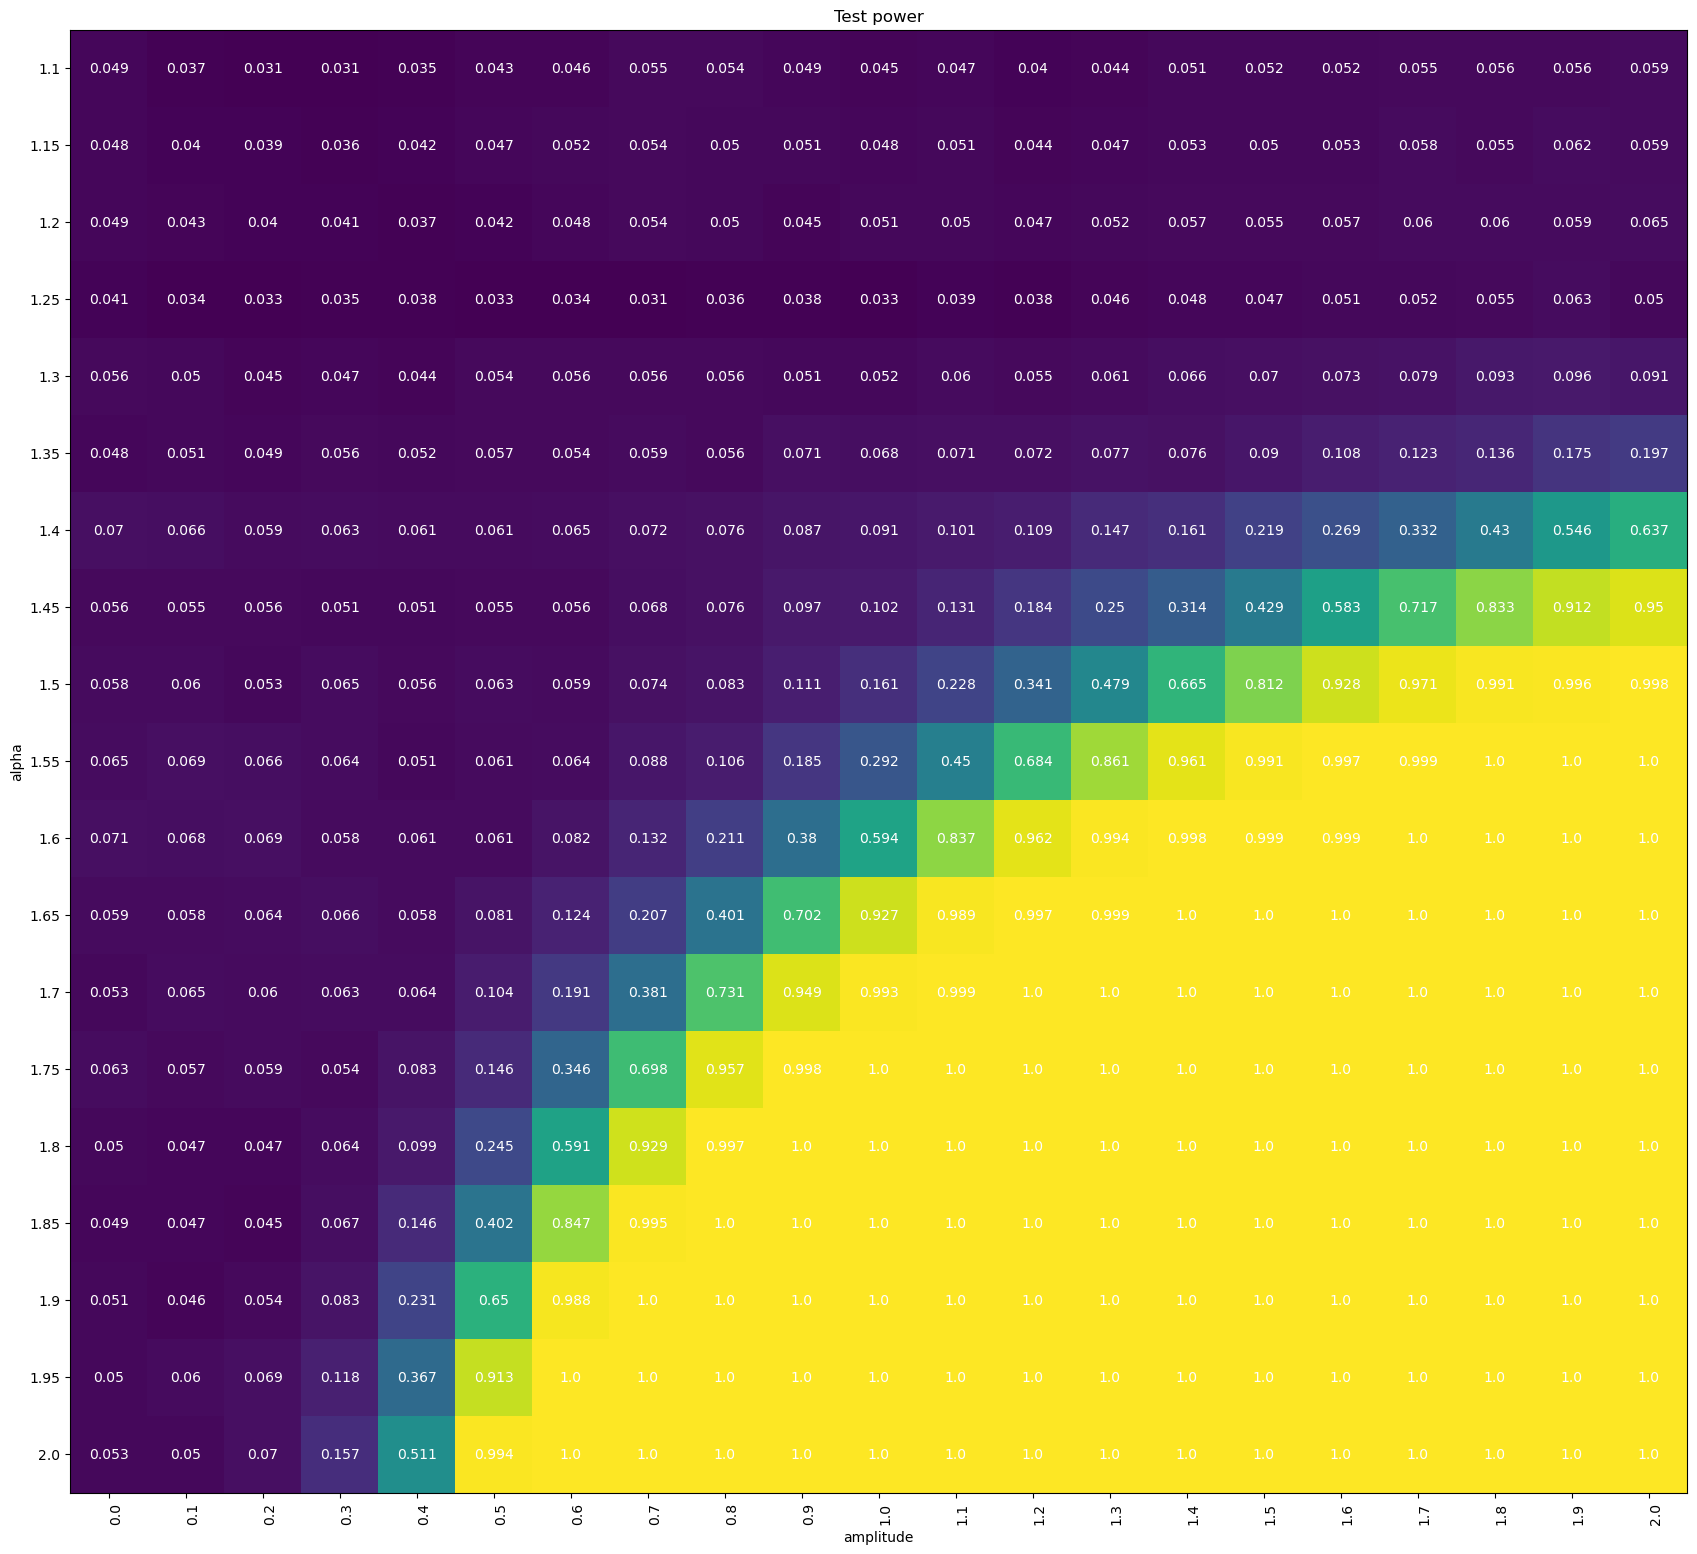

In [7]:
f,ax = plt.subplots(figsize = (21,19))
ax.imshow(test_powers_alpha)

ax.set_xticks(range(0,len(amplitudes)), labels=np.round(amplitudes,1))
ax.set_yticks(range(0,len(alphas)), labels = np.round(alphas,2))

ax.set_xlabel("amplitude")
ax.set_ylabel("alpha")

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(alphas)):
    for j in range(len(amplitudes)):
        text = ax.text(j, i, test_powers_alpha[i][j],
                       ha="center", va="center", color="w")


#ax.scatter(np.linspace(0,20,21), 19*(-1.1+(1.7/((0.1*np.linspace(0,20,21))**(0.2)))), color="red")
plt.title("Test power")
#plt.savefig("GoF-test-powers.pdf")
plt.show()

In [ ]:
#np.savetxt("test_powers_alpha1.1-2_amplitude0-2.txt",np.array(test_powers_alpha))
#print(np.log(2/1.7)/np.log(0.5))
#print(np.log(1.5/1.7)/np.log(2))#
#np.sum(cdist([avg_bcs[k]],betti_curves, "chebyshev")[0]>acc_thresh)/2000
print(power)
print(test_powers)
#print((1.7**5)*(alphas**(-5)))

0.0375
[0]
